In [1]:
import os
import gc
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from pesq import pesq
from metrics import AudioMetrics, AudioMetrics2
from audio_utils import resample, load_audio_file, save_audio_file
from IPython import display

/home/tallninja/dev/Final-Year-Project/Signal-Denoising-Using-Deep-Convolutional-Autoencoders/.env/lib64/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tallninja/dev/Final-Year-Project/Signal-Denoising-Using-Deep-Convolutional-Autoencoders/metrics_utils.py:64: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lpcoeff(speech_frame, model_order):


In [2]:
# allows the output of plotting commands to be displayed directly within the notebook
%matplotlib inline

# ignore depracation warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# set the seed for random number generation in NumPy
# Setting the seed ensures that the sequence of random 
# numbers generated will be the same every time the code is run.
np.random.seed(999)

# set the seed for random number generation in PyTorch
torch.manual_seed(999)

# If running on Cuda set these 2 for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Check GPU is available
GPU_AVAILABLE=torch.cuda.is_available()

if(GPU_AVAILABLE):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if GPU_AVAILABLE else 'cpu')

No GPU available, training on CPU.


In [5]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000          # 3072
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000     # 768

In [6]:
TRAIN_INPUT_DIR = Path('datasets/class_9_train_input')
TRAIN_TARGET_DIR = Path('datasets/clean_trainset_28spk_wav')
TEST_INPUT_DIR = Path('datasets/class_9_test_input')
TEST_TARGET_DIR = Path('datasets/clean_testset_wav')

In [7]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a STFT,
    normalizes and leads to a tensor.
    """
    def __init__(self, clean_files, noisy_files, n_fft=64, hop_length=16):
        super().__init__()
        self.clean_files = sorted(clean_files)
        self.noisy_files = sorted(noisy_files)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_len = 165000

    def __len__(self):
        return len(self.noisy_files)
    
    def __getitem__(self, index):
        # load waf files to waveform tensors
        x_clean = self._load_sample(self.clean_files[index])
        x_noisy = self._load_sample(self.noisy_files[index])

        # apply padding and cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)

        # apply STFT
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft,
                                   hop_length=self.hop_length, normalized=True)

        return x_clean_stft, x_noisy_stft

    
    def _load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
    
    def _prepare_sample(self, waveform):
        """"
        Processes an input waveform, which is a 2D NumPy array
        """
        # converts an input waveform from a PytorchTensor to a NumPy array
        waveform = waveform.numpy()
        # get the length of the audio sequence
        current_len = waveform.shape[1]
        # initialize the output array with zeros
        output = np.zeros((1, self.max_len), dtype='float32')
        # copy the values from the input waveform into the initialized 
        # output array. It ensures that the waveform is placed at the end of the output 
        # array, and if the waveform is longer than self.max_len, it is truncated to fit.
        output[0, -current_len:] = waveform[0, :self.max_len]
        # convert the NumPy array to a PyTorch tensor
        return torch.from_numpy(output)

In [8]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))
test_input_files = sorted(list(TEST_INPUT_DIR.rglob('*.wav')))
test_target_files = sorted(list(TEST_TARGET_DIR.rglob('*.wav')))

In [9]:
print(f"Train Input Files: {len(train_input_files)}")
print(f"Train Target Files: {len(train_target_files)}")
print(f"Test Input Files: {len(test_input_files)}")
print(f"Test Target Files: {len(test_target_files)}")

Train Input Files: 11572
Train Target Files: 11572
Test Input Files: 824
Test Target Files: 824


In [10]:
train_dataset = SpeechDataset(train_target_files, train_input_files, N_FFT, HOP_LENGTH)
test_dataset = SpeechDataset(test_target_files, test_input_files, N_FFT, HOP_LENGTH)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [12]:
def test_set_metrics(test_loader, model):
    metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI"]
    overall_metrics = [[] for i in range(len(metric_names))]
    
    for i,(noisy,clean) in enumerate(test_loader):
        x_est = model(noisy.to(DEVICE), is_istft=True)
        x_est_np = x_est[0].view(-1).detach().cpu().numpy()
        x_c_np = torch.istft(torch.squeeze(clean[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
        audio_metrics = AudioMetrics(x_c_np, x_est_np, SAMPLE_RATE)
        
        overall_metrics[0].append(audio_metrics.CSIG)
        overall_metrics[1].append(audio_metrics.CBAK)
        overall_metrics[2].append(audio_metrics.COVL)
        overall_metrics[3].append(audio_metrics.PESQ)
        overall_metrics[4].append(audio_metrics.SSNR)
        overall_metrics[5].append(audio_metrics.STOI)
    
    metrics = dict()
    for i in range(len(metric_names)):
        metrics[metric_names[i]] ={'mean': np.mean(overall_metrics[i]), 'std_dev': np.std(overall_metrics[i])} 
    
    return metrics

In [13]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [14]:
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [15]:
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [16]:
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [17]:
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

In [18]:
class DCUnet20(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)
        self.encoders = []
        self.model_length = 20 // 2
        
        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             filter_size=self.enc_kernel_sizes[i], stride_size=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i])
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 filter_size=self.dec_kernel_sizes[i], stride_size=self.dec_strides[i], padding=self.dec_paddings[i],
                                 output_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)
       
        
    def forward(self, x, is_istft=True):
        # print('x : ', x.shape)
        orig_x = x
        xs = []
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
            # print('Encoder : ', x.shape)
            
        p = x
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            # print('Decoder : ', p.shape)
            p = torch.cat([p, xs[self.model_length - 1 - i]], dim=1)
        
        # u9 - the mask
        
        mask = p
        
        # print('mask : ', mask.shape)
        
        output = mask * orig_x
        output = torch.squeeze(output, 1)


        if is_istft:
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

    
    def set_size(self, model_complexity, model_depth=20, input_channels=1):

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3), 
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (2, 1), #
                                (2, 2), #
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))

## Loss Function

In [19]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
    x_ = torch.squeeze(x_, 1)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

wonky_samples = []

def get_metrics_on_loader(loader, net, use_net=True):
    net.eval()
    # Original test metrics
    scale_factor = 32768
    # metric_names = ["CSIG","CBAK","COVL","PESQ","SSNR","STOI","SNR "]
    metric_names = ["PESQ-WB","PESQ-NB","SNR","SSNR","STOI"]
    overall_metrics = [[] for i in range(5)]
    for i, data in enumerate(loader):
        if (i+1)%10==0:
            end_str = "\n"
        else:
            end_str = ","
        #print(i,end=end_str)
        if i in wonky_samples:
            print("Something's up with this sample. Passing...")
        else:
            noisy = data[0]
            clean = data[1]
            if use_net: # Forward of net returns the istft version
                x_est = net(noisy.to(DEVICE), is_istft=True)
                x_est_np = x_est.view(-1).detach().cpu().numpy()
            else:
                x_est_np = torch.istft(torch.squeeze(noisy, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
            x_clean_np = torch.istft(torch.squeeze(clean, 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
            
        
            metrics = AudioMetrics2(x_clean_np, x_est_np, 48000)
            
            ref_wb = resample(x_clean_np, 48000, 16000)
            deg_wb = resample(x_est_np, 48000, 16000)
            pesq_wb = pesq(16000, ref_wb, deg_wb, 'wb')
            
            ref_nb = resample(x_clean_np, 48000, 8000)
            deg_nb = resample(x_est_np, 48000, 8000)
            pesq_nb = pesq(8000, ref_nb, deg_nb, 'nb')

            #print(new_scores)
            #print(metrics.PESQ, metrics.STOI)

            overall_metrics[0].append(pesq_wb)
            overall_metrics[1].append(pesq_nb)
            overall_metrics[2].append(metrics.SNR)
            overall_metrics[3].append(metrics.SSNR)
            overall_metrics[4].append(metrics.STOI)
    print()
    print("Sample metrics computed")
    results = {}
    for i in range(5):
        temp = {}
        temp["Mean"] =  np.mean(overall_metrics[i])
        temp["STD"]  =  np.std(overall_metrics[i])
        temp["Min"]  =  min(overall_metrics[i])
        temp["Max"]  =  max(overall_metrics[i])
        results[metric_names[i]] = temp
    print("Averages computed")
    if use_net:
        addon = "(cleaned by model)"
    else:
        addon = "(pre denoising)"
    print("Metrics on test data",addon)
    for i in range(5):
        print("{} : {:.3f}+/-{:.3f}".format(metric_names[i], np.mean(overall_metrics[i]), np.std(overall_metrics[i])))
    return results

## Description of epoch training

In [20]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

In [21]:
def test_epoch(net, test_loader, loss_fn, use_net=True):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    '''
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        # Calc the metrics here
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter
    '''
    
    #print("Actual compute done...testing now")
    
    testmet = get_metrics_on_loader(test_loader,net,use_net)

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss, testmet

In [22]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        test_loss = 0
        scheduler.step()
        
        with torch.no_grad():
            test_loss, testmet = test_epoch(net, test_loader, loss_fn, use_net=True)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print(
            f"Epoch: {epoch + 1}/{epochs}...",
              f"Train Loss: {train_loss:.6f}...",
                f"Test Loss: {test_loss:.6f}")

    return train_loss, test_loss

## Train Model

In [23]:
# # clear cache
gc.collect()
torch.cuda.empty_cache()

model = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = wsdr_fn
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [24]:
# train_losses, test_losses = train(model, train_loader, test_loader, loss_fn, optimizer, scheduler, 4)

In [25]:
# torch.save(model.state_dict(), 'weights.pth')

## Using trained weights to run inference

In [26]:
BASE_DIR = os.path.curdir

weights = os.path.join(BASE_DIR, "weights", "mixed.pth")
model = DCUnet20(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
model_state = torch.load(weights, map_location=DEVICE)
model.load_state_dict(model_state)

model.eval()

DCUnet20(
  (encoder0): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(1, 31, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0))
      (im_conv): Conv2d(1, 31, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (encoder1): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(31, 31, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
      (im_conv): Conv2d(31, 31, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (enc

In [38]:
SAMPLES_DIR = os.path.join(os.path.curdir, 'samples')
NOISY_SAMPLE_PATH = os.path.join(SAMPLES_DIR, 'noisy.wav')
CLEAN_SAMPLE_PATH = os.path.join(SAMPLES_DIR, 'clean.wav')
DENOISED_SAMPLE_PATH = os.path.join(SAMPLES_DIR, 'denoised.wav')

x_noisy = load_audio_file(file_path=NOISY_SAMPLE_PATH)
x_clean = load_audio_file(file_path=CLEAN_SAMPLE_PATH)

x_noisy_stft = torch.stft(input=x_noisy, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
x_clean_stft = torch.stft(input=x_clean, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

x_denoised = model(x_noisy_stft[None, ...], is_istft=True)

x_clean = torch.istft(torch.squeeze(x_clean_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
x_noisy = torch.istft(torch.squeeze(x_noisy_stft[0], 1), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy()
x_denoised = x_denoised[0].view(-1).detach().cpu().numpy()

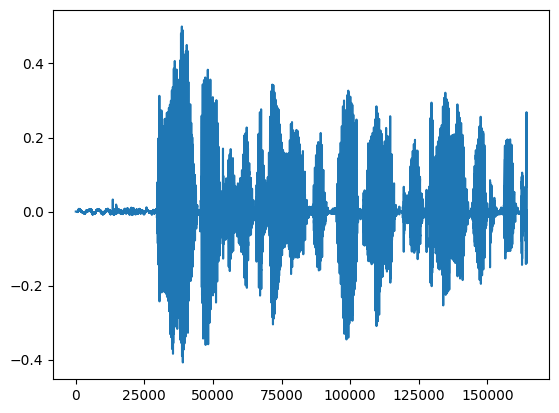

In [33]:
plt.plot(x_clean)
display.Audio(x_clean, rate=SAMPLE_RATE)

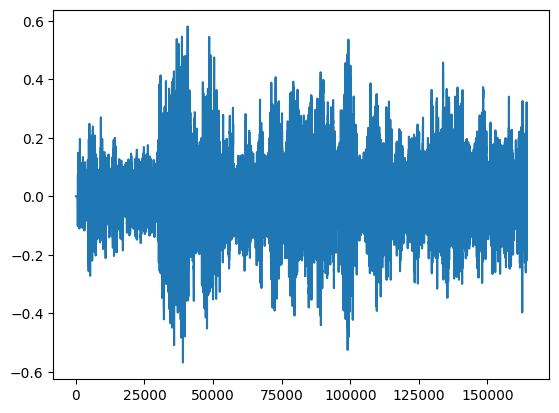

In [29]:
plt.plot(x_noisy)
display.Audio(x_noisy, rate=SAMPLE_RATE)

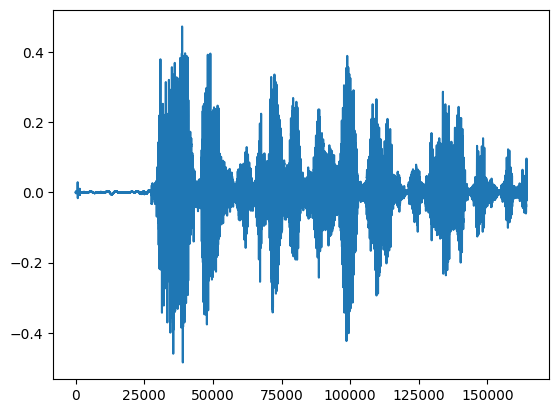

In [39]:
plt.plot(x_denoised)
display.Audio(x_denoised, rate=SAMPLE_RATE)

In [31]:
save_audio_file(DENOISED_SAMPLE_PATH, x_denoised, SAMPLE_RATE)